# Contries classification

imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import geopandas as gpd
import plotly.express as px
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np


import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Read data

In [2]:
data = pd.read_csv('data/Country-data.csv')
data.head()
data.describe()
#mean -> moyenne
#std -> variance

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## Correlation between features

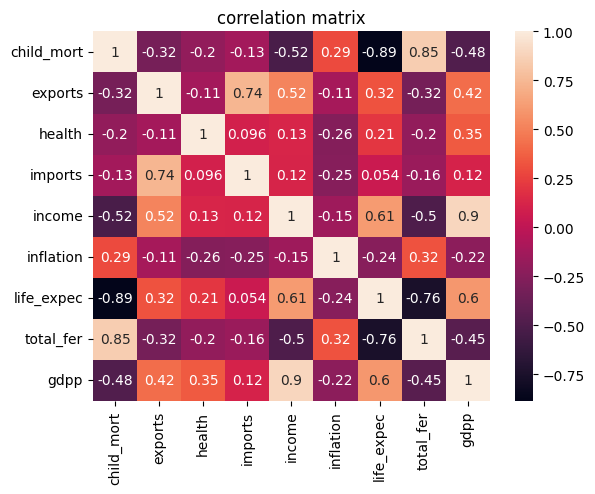

In [3]:
corr = data.drop('country', axis=1).corr()
sns.heatmap(corr, annot=True)
plt.title("correlation matrix")
plt.show()

## Distrubution of values

Text(0.5, 1.0, 'Distribution of GDP per capita')

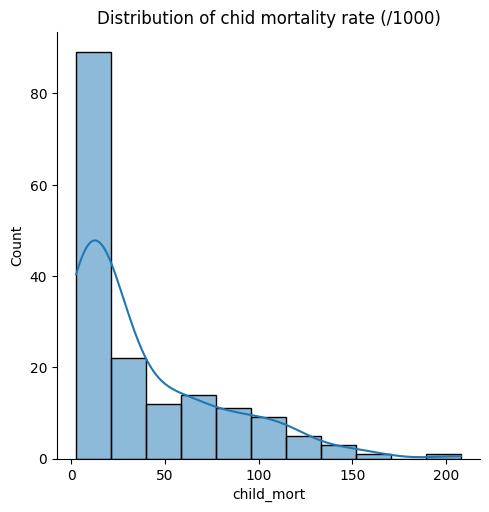

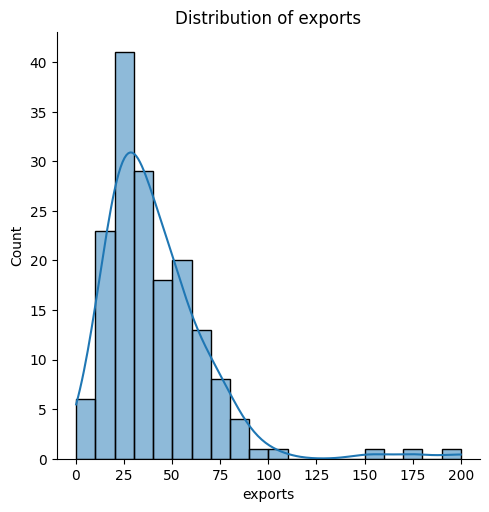

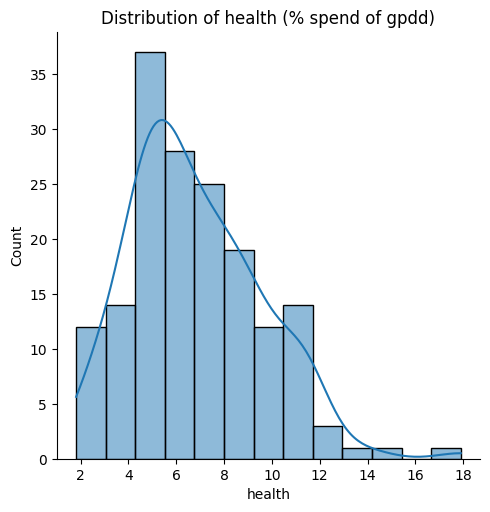

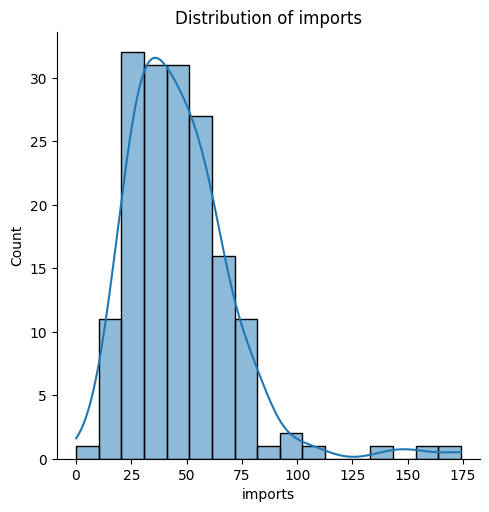

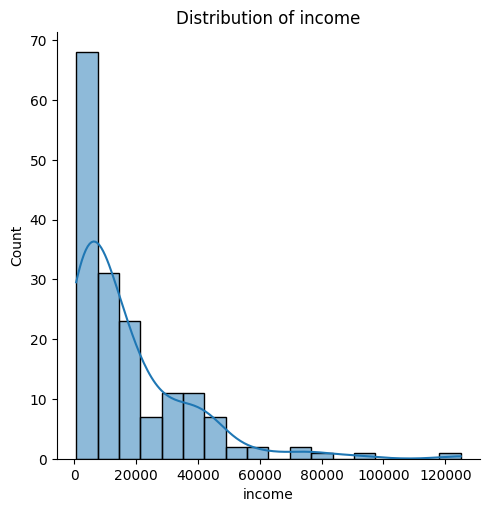

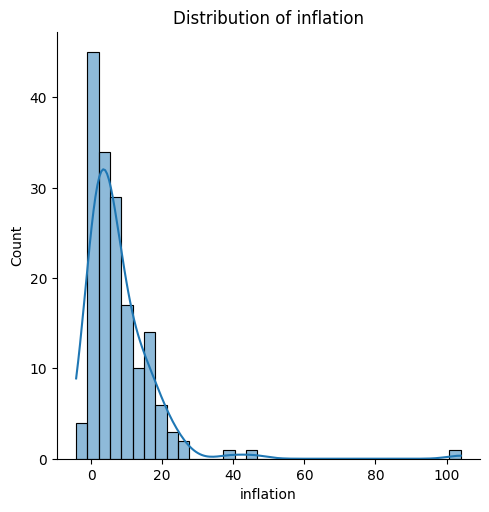

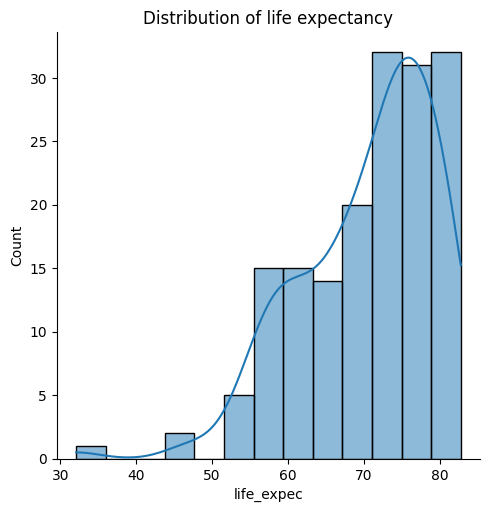

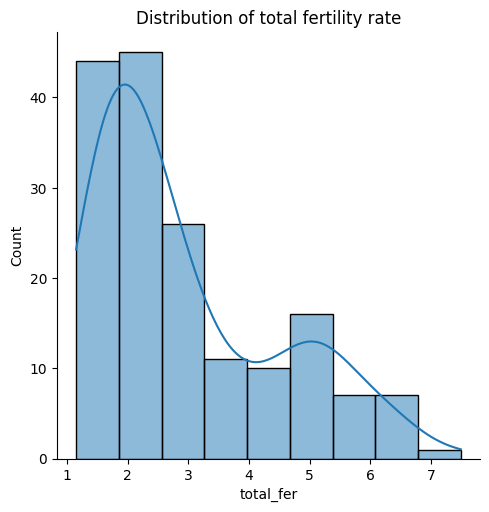

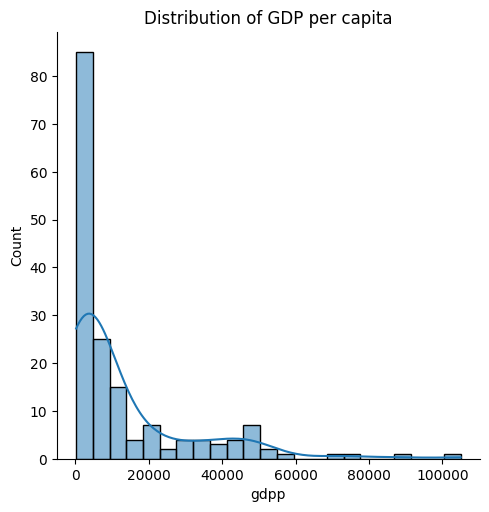

In [4]:
cm = sns.displot(data['child_mort'],kde=True)
plt.title("Distribution of chid mortality rate (/1000)")
exports = sns.displot(data['exports'],kde=True)
plt.title("Distribution of exports")
health = sns.displot(data['health'],kde=True)
plt.title("Distribution of health (% spend of gpdd)")
imports = sns.displot(data['imports'],kde=True)
plt.title("Distribution of imports")
income = sns.displot(data['income'],kde=True)
plt.title("Distribution of income")
inflation = sns.displot(data['inflation'],kde=True)
plt.title("Distribution of inflation")
life_expec = sns.displot(data['life_expec'],kde=True)
plt.title("Distribution of life expectancy")
total_fer = sns.displot(data['total_fer'],kde=True)
plt.title("Distribution of total fertility rate")
gdpp = sns.displot(data['gdpp'],kde=True)
plt.title("Distribution of GDP per capita")

## function in order to saw the n best and worst countries by feature

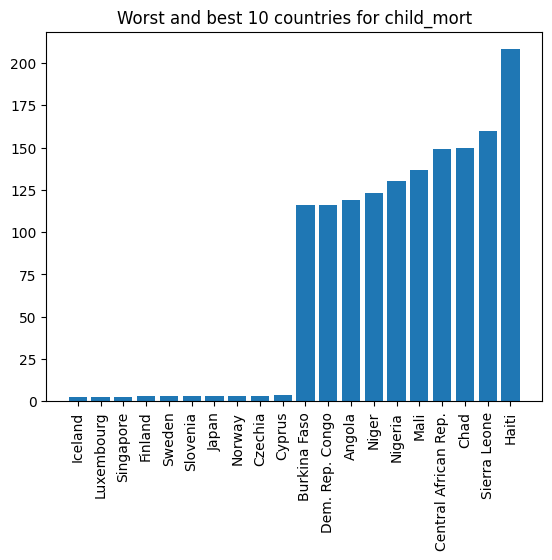

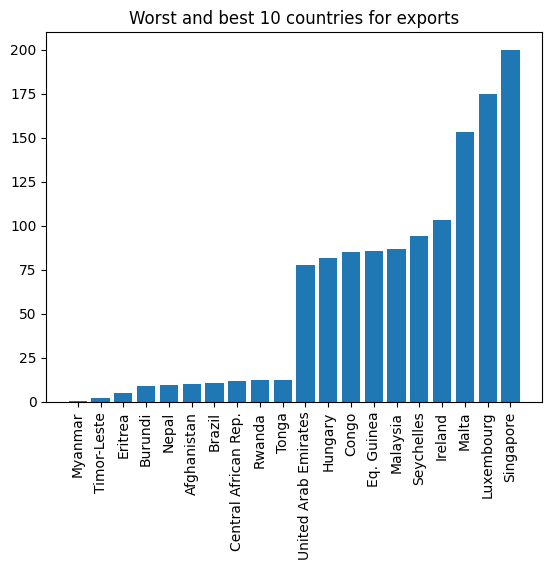

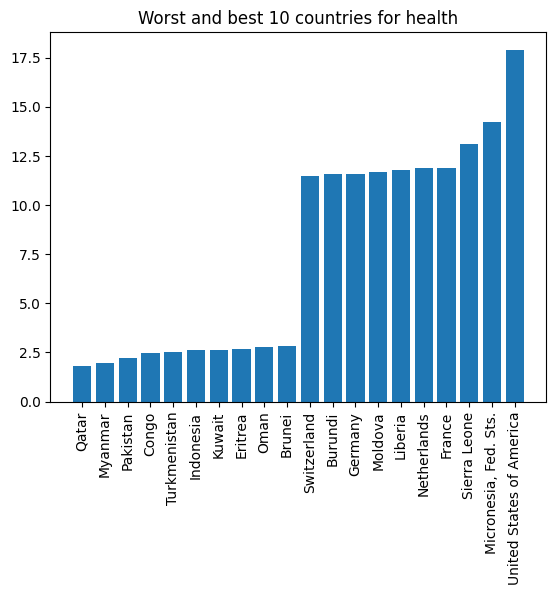

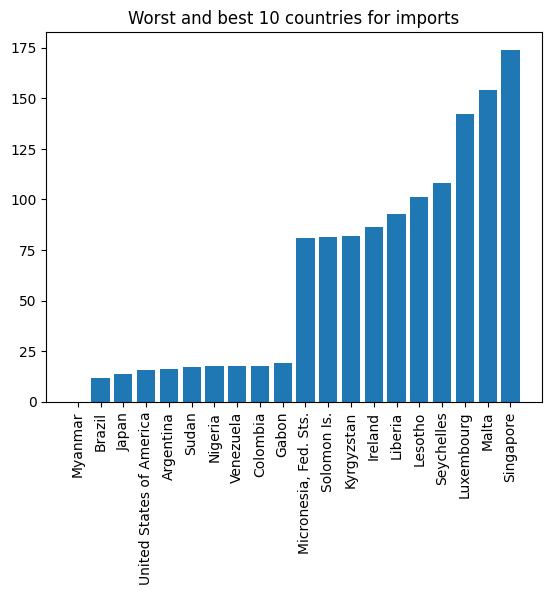

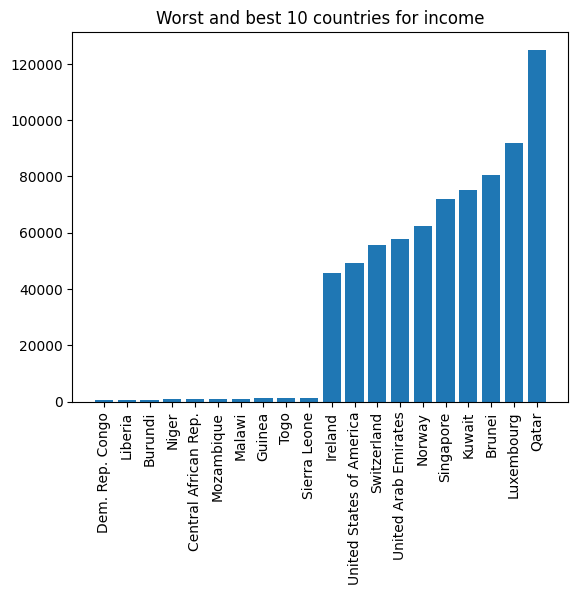

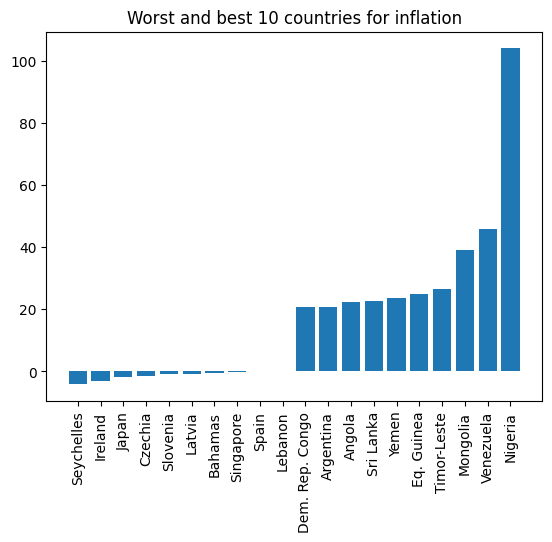

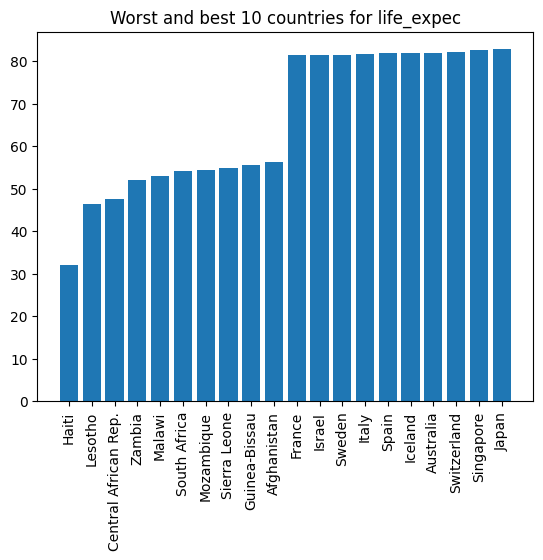

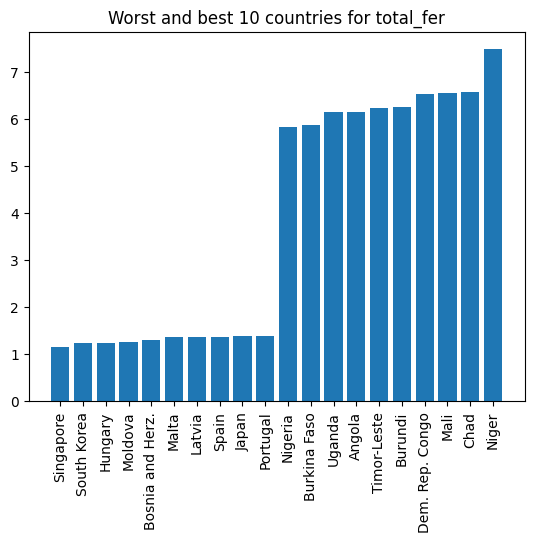

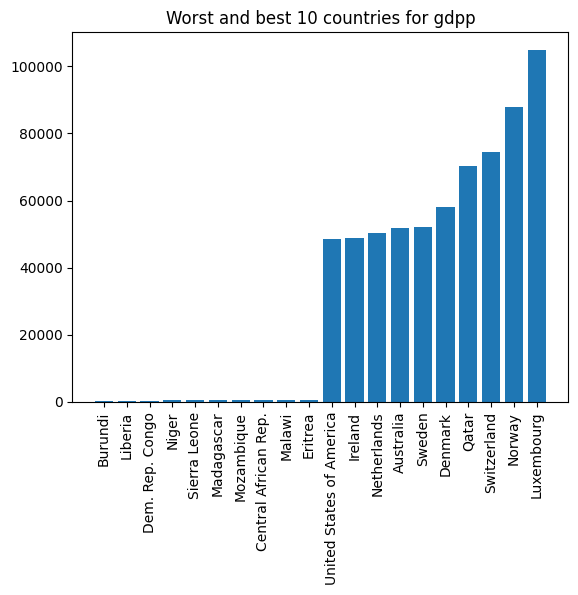

In [5]:
def worst_and_best(data,feature,n):
    infos = data[["country",feature]].sort_values(by=feature)
    res =  pd.concat([infos.head(n),infos.tail(n)])
    plt.bar(res["country"],res[feature])
    plt.xticks(rotation=90)
    plt.title(f"Worst and best {n} countries for {feature}")
    plt.show()
    
    
for col in data.columns[1:]:
    worst_and_best(data,col,10)

In order to find examples of each category i use the previous functions for every feature and for 5 countries. 

Then i count every aparition of each one in the top or bottom stats

Don't need help: Luxembourg, Singapore and Seychelles

Could need help: Mali, Chad, Pakistan

Need help: Haiti, Myanmar,Congo, Niger, Liberia

# Choice of algorithm and initialise pipeline

### MinMaxScalling

In [6]:

def preprocess(data,technic):
    if technic == "minmax":
    
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data.drop('country', axis=1))
        data_scaled = pd.DataFrame(data_scaled, columns=data.columns[1:])
        data_scaled = pd.concat([data['country'], data_scaled], axis=1)
        data_scaled.head()
        return data_scaled
    elif technic == "standardscaler":
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data.drop('country', axis=1))
        data_scaled = pd.DataFrame(data_scaled, columns=data.columns[1:])
        data_scaled = pd.concat([data['country'], data_scaled], axis=1)
        data_scaled.head()
        return data_scaled
    elif technic == "both":
        scalerOne = MinMaxScaler()
        scalerTwo = StandardScaler()
        data_scaled = scalerOne.fit_transform(data.drop('country', axis=1))
        data_scaled = pd.DataFrame(data_scaled, columns=data.columns[1:])
        data_scaled = scalerTwo.fit_transform(data_scaled)
        data_scaled = pd.DataFrame(data_scaled, columns=data.columns[1:])
        data_scaled = pd.concat([data['country'], data_scaled], axis=1)
        data_scaled.head()
        return data_scaled
        
   
preprocessed_data_v1 = preprocess(data,"both")

### Reduce dimension

In [7]:
def reduce_dim(data,technic,pca_value = None):
    #Add new technic
    if technic == "pca":
        if pca_value is not None:
            PCA_VALUE = pca_value
        else:
            
            PCA_VALUE = 0.95
        pca = PCA(n_components=PCA_VALUE)
        data_pca = pca.fit_transform(data.drop('country', axis=1))
        
        columns = [f'pca{i+1}' for i in range(data_pca.shape[1])]

        data_pca = pd.DataFrame(data_pca,columns=columns)
        data_pca = pd.concat([data['country'], data_pca], axis=1)
        print(f"From {data.shape[1]-1} to {data_pca.shape[1]-1} features")
        return data_pca
    
pca_data_v1 = reduce_dim(preprocessed_data_v1,"pca")

From 9 to 6 features


### Clustering

From 9 to 6 features


c:\Users\mathy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


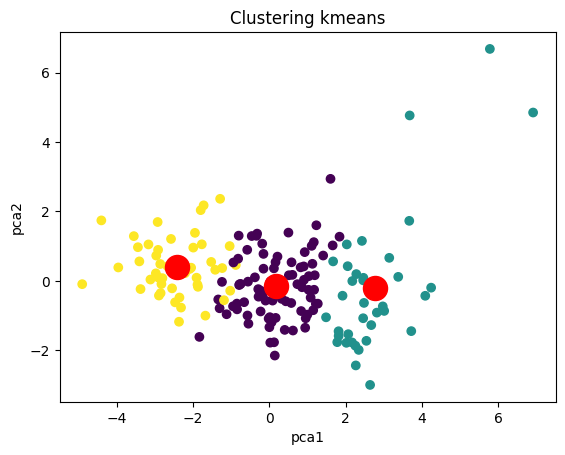

From 9 to 6 features


c:\Users\mathy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but EllipticEnvelope was fitted with feature names
  warnings.warn(
c:\Users\mathy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but EllipticEnvelope was fitted with feature names
  warnings.warn(
c:\Users\mathy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but EllipticEnvelope was fitted with feature names
  warnings.warn(


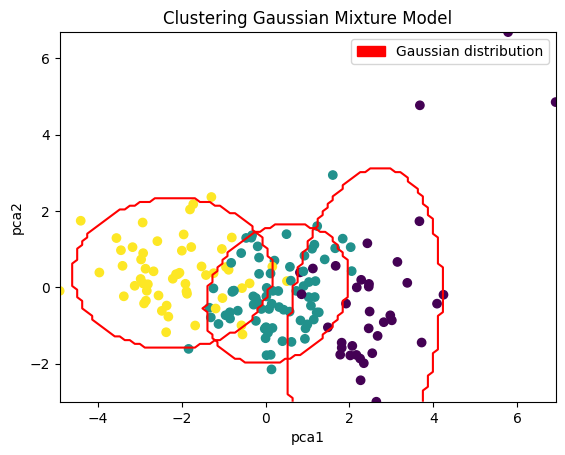

From 9 to 6 features


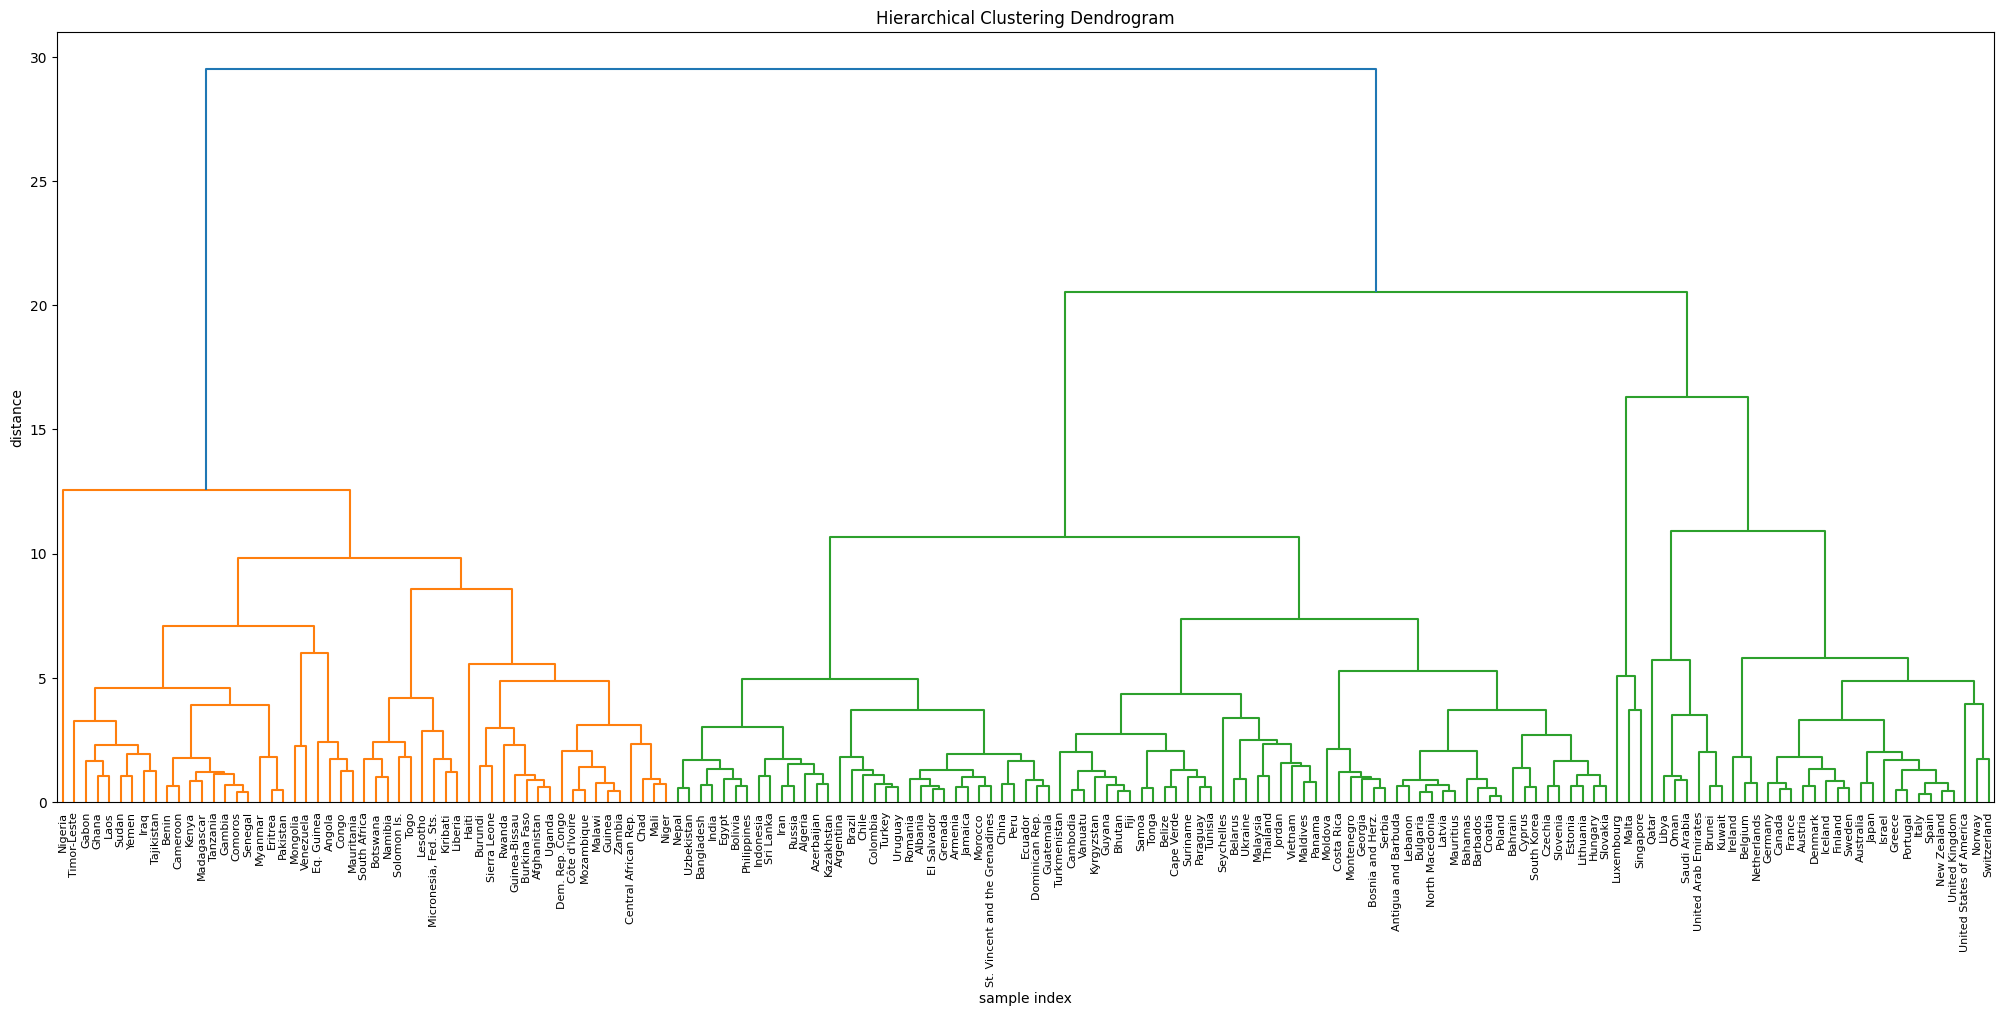

,country,pca1,pca2,pca3,pca4,pca5,pca6,cluster
0,Afghanistan,-2.913025,0.095621,-0.718118,1.005255,-0.158310,-0.254597,Need help
1,Albania,0.429911,-0.588156,-0.333486,-1.161059,0.174677,0.084579,Could need help
2,Algeria,-0.285225,-0.455174,1.221505,-0.868115,0.156475,-0.401696,Could need help
3,Angola,-2.932423,1.695555,1.525044,0.839625,-0.273209,-0.547996,Need help
4,Antigua and Barbuda,1.033576,0.136659,-0.225721,-0.847063,-0.193007,-0.206919,Could need help
...,...,...,...,...,...,...,...,...
162,Vanuatu,-0.820631,0.639570,-0.389923,-0.706595,-0.395748,0.009059,Could need help
163,Venezuela,-0.551036,-1.233886,3.101350,-0.115311,2.082581,0.097274,Need help
164,Vietnam,0.498524,1.390744,-0.238526,-1.074098,1.176081,0.051607,Could need help
165,Yemen,-1.887451,-0.109453,1.109752,0.056257,0.618365,-0.540917,Need help


In [8]:
def clustering(data,technic):
    if technic == "kmeans":
        kmeans = KMeans(n_clusters=3)
        kmeans.fit(data.drop('country', axis=1))
        newData = data.copy()

        
        newData['cluster'] = kmeans.labels_
        
        
        # Plot the clusters
        plt.scatter(newData['pca1'], newData['pca2'], c=kmeans.labels_, cmap='viridis')

        # Plot the centroids
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
        plt.title("Clustering kmeans")
        plt.xlabel("pca1")
        plt.ylabel("pca2")
        plt.show()
        
    elif technic == "hierarchical":
        hierarchical = AgglomerativeClustering(n_clusters=3)
        hierarchical.fit(data.drop('country', axis=1))
        newData = data.copy()
        newData['cluster'] = hierarchical.labels_
        # Plot the dendrogram
        Z = linkage(data.drop('country', axis=1), 'ward')

        # plot dendrogram
        plt.figure(figsize=(25, 10))
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        dendrogram(
            Z,
            labels = data["country"].values,
            leaf_rotation=90.,  # rotates the x axis labels
            leaf_font_size=8.,  # font size for the x axis labels
        )
        plt.show()
         
    elif technic == "gaussian":
        gaussian = GaussianMixture(n_components=3)
        gaussian.fit(data.drop('country', axis=1))
        newData = data.copy()
        newData['cluster'] = gaussian.predict(data.drop('country', axis=1))
        plt.scatter(newData['pca1'], newData['pca2'], c=newData['cluster'], cmap='viridis')

        # Plot the Gaussian distributions
        for i in range(3):  # Assuming you have 3 clusters
            cluster_data = newData[newData['cluster'] == i][['pca1', 'pca2']]
            if len(cluster_data) > 1:  # Check if there are at least two data points in the cluster
                # Fit an EllipticEnvelope
                cov = EllipticEnvelope(random_state=0).fit(cluster_data)
                # Create grid
                xx, yy = np.meshgrid(np.linspace(newData['pca1'].min(), newData['pca1'].max(), 100), np.linspace(newData['pca2'].min(), newData['pca2'].max(), 100))
                zz = cov.predict(np.c_[xx.ravel(), yy.ravel()])
                zz = zz.reshape(xx.shape)
                # Draw the ellipse
                plt.contour(xx, yy, zz, levels=[0], colors='r')

        # Create a custom legend
        legend_elements = [Patch(facecolor='r', edgecolor='r', label='Gaussian distribution')]
        plt.legend(handles=legend_elements)

        plt.title("Clustering Gaussian Mixture Model")
        plt.xlabel("pca1")
        plt.ylabel("pca2")
        plt.show()

               
    #change labels to be more readable
    dont_need = newData.loc[newData["country"] == "Luxembourg"]['cluster'].values[0]
    could_need = newData.loc[newData["country"] == "China"]['cluster'].values[0]
    need = newData.loc[newData["country"] == "Haiti"]['cluster'].values[0]
    newData['cluster'] = newData['cluster'].replace({dont_need: 'Dont need help', could_need: 'Could need help', need: 'Need help'})

    newData.to_csv(f"data/clustered_data_with_{technic}.csv")
    return newData
    

clustering(reduce_dim(preprocessed_data_v1,"pca"),"kmeans")
clustering(reduce_dim(preprocessed_data_v1,"pca"),"gaussian")
clustering(reduce_dim(preprocessed_data_v1,"pca"),"hierarchical")

### First plot

In [9]:
def plot_2D(technic):
    cmap = {"Need help": 'red', "Could need help": 'yellow', "Dont need help": 'green' }
    cluster = pd.read_csv(f'data/clustered_data_with_{technic}.csv')  
    #select features
    features = cluster.drop(['country', 'cluster'], axis=1).columns
    #transform the data in 2D with a new PCA

    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(cluster[features])
    data_pca = pd.DataFrame(data_pca, columns=['pca1', 'pca2'])
    data_pca = pd.concat([cluster['country'], data_pca, cluster['cluster']], axis=1)

    #plot the data
    fig = px.scatter(data_pca, x='pca1', y='pca2', color='cluster', hover_name='country', title=f'PCA of the clustered data with {technic}', color_discrete_map=cmap)
    fig.show()


plot_2D("hierarchical")
plot_2D("kmeans")
plot_2D("gaussian")

c:\Users\mathy\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


c:\Users\mathy\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



c:\Users\mathy\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### Plot Map (put in gray no data countries)

C:\Users\mathy\AppData\Local\Temp\ipykernel_432\2782243971.py:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



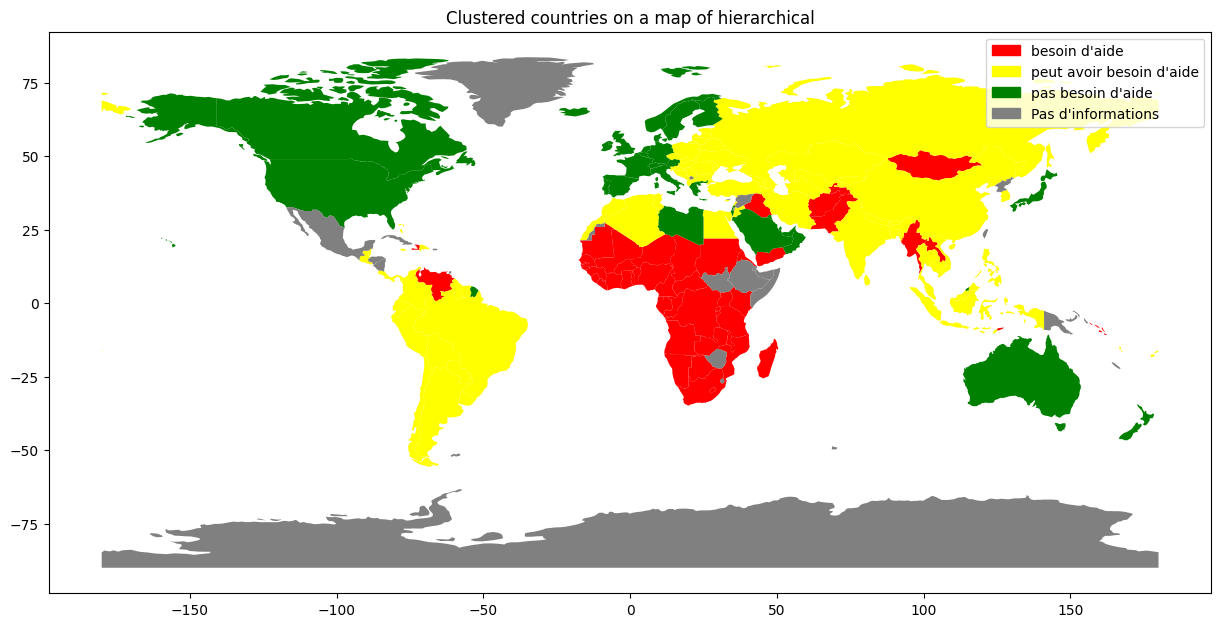

C:\Users\mathy\AppData\Local\Temp\ipykernel_432\2782243971.py:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



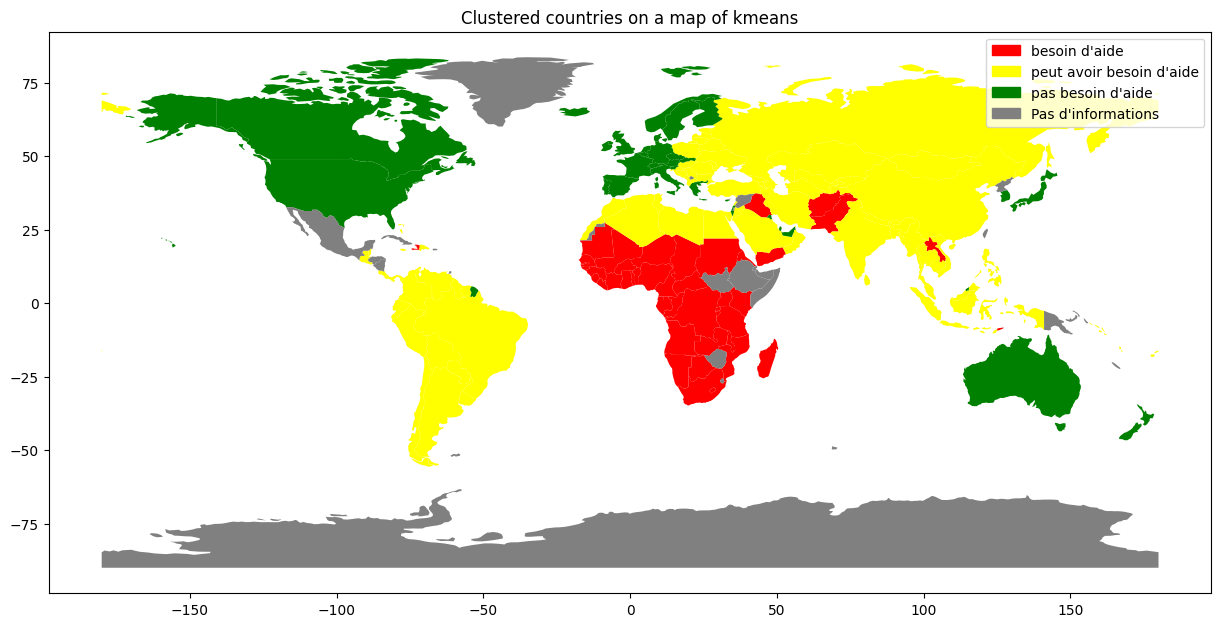

C:\Users\mathy\AppData\Local\Temp\ipykernel_432\2782243971.py:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



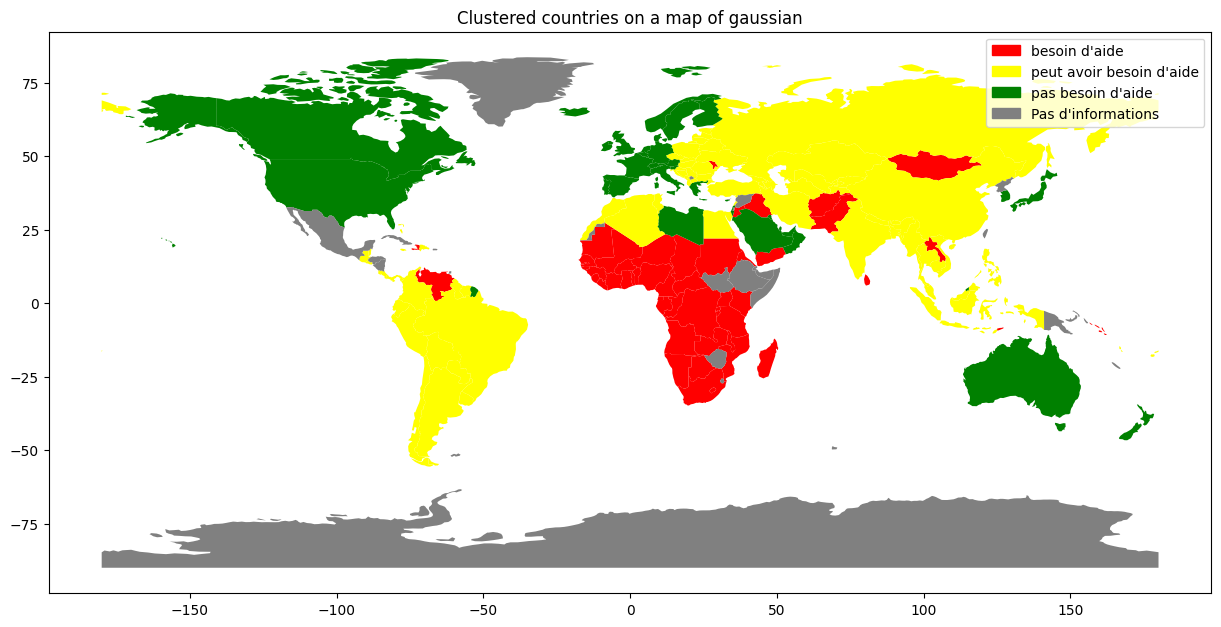

In [10]:

def plot_map(technic):
    #get data
    cluster = pd.read_csv(f'data/clustered_data_with_{technic}.csv')
    #create geoDataFrame
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.to_csv("data/world.csv")

    world = world.merge(cluster,left_on='name',right_on='country',how='left')
    world['cluster'] = world['cluster'].fillna('Other')

    world.to_csv("data/test.csv")



    fig, ax = plt.subplots(1, 1,figsize=(15, 10))

    # Create a color map
    cmap = {"Need help": 'red', "Could need help": 'yellow', "Dont need help": 'green', 'Other': 'grey'}

    # Create a label map
    labels = {"Need help": "besoin d'aide", "Could need help": "peut avoir besoin d'aide", "Dont need help": "pas besoin d'aide","Other":"Pas d'informations"}

    # Plot each cluster with a different color
    for cluster in ["Need help", "Could need help", "Dont need help","Other"]:
        world[world['cluster'] == cluster].plot(color=cmap[cluster], ax=ax)

    # Create a legend
    patchList = []
    for key in cmap:
        data_key = mpatches.Patch(color=cmap[key], label=labels[key])
        patchList.append(data_key)

    plt.legend(handles=patchList)
    plt.title(f"Clustered countries on a map of {technic}")

    plt.show()

plot_map("hierarchical")
plot_map("kmeans")
plot_map("gaussian")


### Post analyse of cluster

Silhouette score : -0.039851101182845475 for kmeans
Davies score : 22.754877631850153 for kmeans
Silhouette score : -0.0511058948001078 for hierarchical
Davies score : 12.39566494955245 for hierarchical
Silhouette score : -0.043967812679701845 for gaussian
Davies score : 13.336743938951232 for gaussian


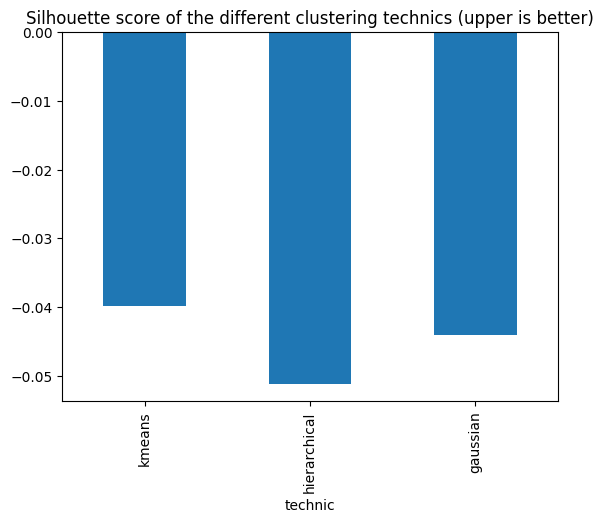

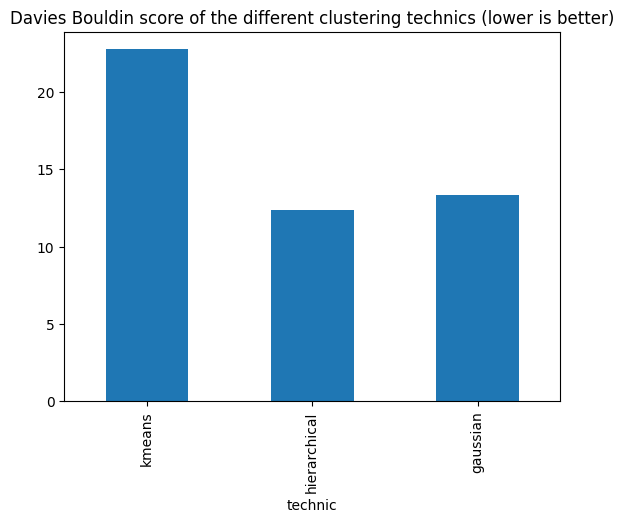

In [11]:
def post_analyse():
    technics = ["kmeans","hierarchical","gaussian"]
    res =[]
    for technic in technics:
        data = pd.read_csv(f'data/clustered_data_with_{technic}.csv')
        #silhouette score (between -1 and 1)  1 good -1 bad
        silhouette = silhouette_score(data.drop(['country', 'cluster'], axis=1), data['cluster'])
        print(f"Silhouette score : {silhouette} for {technic}")
        #davies-Bouldin score (lower is better)
        davies = davies_bouldin_score(data.drop(['country', 'cluster'], axis=1), data['cluster'])
        print(f"Davies score : {davies} for {technic}")
        infos = {"technic": technic, 
                 "silhouette": silhouette,
                 'davies_boudlin': davies}
        res.append(infos)  
        
    df = pd.DataFrame(res)
    
    df.set_index('technic', inplace=True)
    df['silhouette'].plot(kind='bar')
    plt.title("Silhouette score of the different clustering technics (upper is better)")
    plt.show()
    df['davies_boudlin'].plot(kind='bar')
    plt.title("Davies Bouldin score of the different clustering technics (lower is better)")
    plt.show()
    
post_analyse()